In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import IPython
import IPython.display
from ipywidgets import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import json
from tensorflow import keras
from keras import layers
from skimage.restoration import denoise_tv_chambolle

from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list

%matplotlib widget

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
N = 10
#T = 32
#total_range = T+200

In [3]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list).copy()

In [4]:
def radius_list(xs:np.ndarray, ys:np.ndarray):
    assert xs.ndim == 1 and ys.ndim == 1
    rad_list = [0.]
    disp_list = []
    for i in range(1, len(xs)):
        rad_list.append(np.sqrt((xs[i] - xs[0])**2 + (ys[i] - ys[0])**2))
        disp_list.append(np.sqrt((xs[i] - xs[i-1])**2 + (ys[i] - ys[i-1])**2))
    return np.array(rad_list) / np.mean(disp_list) / len(xs)

In [5]:
def shuffle(data, *args):
    shuffle_index = np.arange(len(data))
    np.random.shuffle(shuffle_index)
    args = list(args)
    for i, arg in enumerate(args):
        args[i] = arg[shuffle_index]
    return data[shuffle_index], *args

In [7]:
input_data = []
input_length = []
input_label = []

for alpha in np.arange(0.001, 2, 0.1):
    for T in range(32, 34, 1):
        total_range = T+200
        D = np.random.uniform(low=0.01, high=10.0)
        trajs_model, labels_model = models_phenom().single_state(N=N,
                                                                 L=None,
                                                                 T=total_range,
                                                                 alphas=alpha,
                                                                 Ds=[D, 0],
                                                                )
        for n_traj in range(N):
            # var_length = np.random.randint(-4, 4)
            xs = trajs_model[:, n_traj, 0][:T]
            ys = trajs_model[:, n_traj, 1][:T]
            rad_list = radius_list(xs, ys)

            xs = xs / (np.std(xs))
            xs = np.cumsum(abs(uncumulate(xs))) / T
            ys = ys / (np.std(ys))
            ys = np.cumsum(abs(uncumulate(ys))) / T

            input_list = np.vstack((xs, rad_list)).T
            input_data.append(input_list)
            input_label.append(alpha)
            input_length.append(T)

            input_list = np.vstack((ys, rad_list)).T
            input_data.append(input_list)
            input_label.append(alpha)
            input_length.append(T)

            for _ in range(5):
                # var_length = np.random.randint(-4, 4)
                random_start = np.random.randint(10, total_range - T)
                xs = trajs_model[:, n_traj, 0][random_start:random_start + T]
                ys = trajs_model[:, n_traj, 1][random_start:random_start + T]
                rad_list = radius_list(xs, ys)

                xs = xs / (np.std(xs))
                xs = np.cumsum(abs(uncumulate(xs))) / T
                ys = ys / (np.std(ys))
                ys = np.cumsum(abs(uncumulate(ys))) / T

                input_list = np.vstack((xs, rad_list)).T
                input_data.append(input_list)
                input_label.append(alpha)
                input_length.append(T)

                input_list = np.vstack((ys, rad_list)).T
                input_data.append(input_list)
                input_label.append(alpha)
                input_length.append(T)

input_data = np.array(input_data)
input_label = np.array(input_label)
input_length = np.array(input_length)

/var/folders/6j/m9h9rcs52qzbtxk18qybv2xw0000gn/T/ipykernel_14968/1232481044.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_data = np.array(input_data)


In [8]:
valid_data = []
valid_length = []
valid_label = []

for alpha in np.arange(0.001, 2, 0.1):
    for T in range(32, 34, 1):
        total_range = T+200
        D = np.random.uniform(low=0.01, high=10.0)
        trajs_model, labels_model = models_phenom().single_state(N=3,
                                                                 L=None,
                                                                 T=total_range,
                                                                 alphas=alpha,
                                                                 Ds=[D, 0],
                                                                )
        for n_traj in range(3):
            for _ in range(5):
                random_start = np.random.randint(0, total_range - T)
                xs = trajs_model[:, n_traj, 0][random_start:random_start + T]
                ys = trajs_model[:, n_traj, 1][random_start:random_start + T]
                rad_list = radius_list(xs, ys)

                xs = xs / (np.std(xs))
                xs = np.cumsum(abs(uncumulate(xs))) / T
                ys = ys / (np.std(ys))
                ys = np.cumsum(abs(uncumulate(ys))) / T

                input_list = np.vstack((xs, rad_list)).T
                valid_data.append(input_list)
                valid_label.append(alpha)
                valid_length.append(T)

                input_list = np.vstack((ys, rad_list)).T
                valid_data.append(input_list)
                valid_label.append(alpha)
                valid_length.append(T)

valid_data = np.array(valid_data)
valid_label = np.array(valid_label)
valid_length = np.array(valid_length)

/var/folders/6j/m9h9rcs52qzbtxk18qybv2xw0000gn/T/ipykernel_14968/1787803620.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  valid_data = np.array(valid_data)


In [9]:
print(len(input_data), len(input_label), len(input_length))
train_input, train_label, train_length = shuffle(input_data, input_label, input_length)
val_input, val_label, val_length = shuffle(valid_data, valid_label, valid_length)

4800 4800 4800


In [ ]:
"""
print(input_data.shape, input_label.shape)
colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_facecolor("black")
for i in range(0, 3000):
    color = color_seq[int(train_label[i]/2. * 255)]
    ax.plot(train_input[i, :, 0], color=color, alpha=0.15, zorder=-1)
ax.set_ylim([0, 1])

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_facecolor("black")
for i in range(0, 3000):
    color = color_seq[int(train_label[i]/2. * 255)]
    ax.plot(train_input[i, :, 1], color=color, alpha=0.15, zorder=-1)

plt.figure()
plt.hist(train_label, bins=np.arange(0, 2, 0.01))
"""

In [ ]:
"""
train_input = train_input.reshape(-1, T, 1, 2)
train_label = train_label.reshape(-1, 1)
val_input = val_input.reshape(-1, T, 1, 2)
val_label = val_label.reshape(-1, 1)
"""

In [10]:
train_input = tf.ragged.constant(train_input)
train_label = tf.ragged.constant(train_label)
train_length = tf.ragged.constant(train_length)
val_input = tf.ragged.constant(val_input)
val_label = tf.ragged.constant(val_label)
val_length = tf.ragged.constant(val_length)

2024-06-02 15:04:23.427425: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-02 15:04:23.427451: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-02 15:04:23.427458: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-02 15:04:23.427489: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-02 15:04:23.427501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
print(f'train_reg_shape:{train_input.shape}\n',
      f'train_label_shape:{train_label.shape}\n',
      f'train_length_shape:{train_length.shape}\n'
      f'val_reg_shape:{val_input.shape}\n',
      f'val_label_shape:{val_label.shape}\n',
      f'val_length_shape:{val_length.shape}\n')

train_reg_shape:(4800, None, None)
 train_label_shape:(4800,)
 train_length_shape:(4800,)
val_reg_shape:(1200, None, None)
 val_label_shape:(1200,)
 val_length_shape:(1200,)



In [13]:
baseline = tf.keras.models.load_model(f'./models/alpha_reg_models/reg_model_32.keras')

In [11]:
"""
# Shape [batch, time, features] => [batch, time, lstm_units]
reg_input = keras.Input(shape=(None, 2) , name="reg_signals", ragged=True)

#x = layers.Conv1D(filters=256, kernel_size=2, strides=1, padding='same')(reg_input)
#x = layers.ConvLSTM1D(filters=256, kernel_size=3, strides=1,
#                      padding='same', dropout=0.1, data_format="channels_last")(reg_input)

length_input = keras.Input(shape=(1,), name='length')
y = layers.Dense(units=16)(length_input)
y = layers.Reshape((8, 2))(y)

x = layers.Concatenate(axis=1)([reg_input, y])
x = layers.Bidirectional(layers.LSTM(256, dropout=0.1))(x)

x = layers.Dense(units=256, activation='leaky_relu')(x)
x = layers.Dense(units=128, activation='leaky_relu')(x)
reg_last_layer = layers.Dense(units=1, activation='relu')(x)

reg_model = keras.Model(
    inputs=[reg_input, length_input],
    outputs=[reg_last_layer],
    name='anomalous_regression')
"""

In [26]:
baseline.trainable = False

# Shape [batch, time, features] => [batch, time, lstm_units]
reg_input = keras.Input(shape=(None, 1, 2) , name="multi_reg_alpha", ragged=True)
length_input = keras.Input(shape=(1,), name='length')

x = layers.Reshape((-1, 1, 2))(reg_input.to_tensor())
y = layers.Dense(units=2, name='length_input_dense')(length_input)

for layer in baseline.layers:
    x = layer(x)

x = layers.Concatenate()([x, y])
x = layers.Dense(units=32, activation='leaky_relu', name='ana_-2')(x)
reg_last_layer = layers.Dense(units=1, activation='relu', name='ana_-1')(x)

reg_model = keras.Model(
    inputs=[reg_input, length_input],
    outputs=[reg_last_layer],
    name='multi_reg_alpha_model')

In [27]:
reg_model.compile(loss=tf.keras.losses.Huber(name='huber_loss'),
                  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(name='MAE'),
                          ])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=20,
                                                  mode='min',
                                                  verbose=2,
                                                  restore_best_weights=True,
                                                  start_from_epoch=3
                                                 )

In [28]:
#keras.utils.plot_model(reg_model, "multi_reg_alpha_model.png", show_shapes=True)
reg_model.summary()

Model: "multi_reg_alpha_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 multi_reg_alpha (InputLaye  [(None, None, 1, 2)]         0         []                            
 r)                                                                                               
                                                                                                  
 input.to_tensor_3 (Instanc  (None, None, 1, 2)           0         ['multi_reg_alpha[0][0]']     
 eMethod)                                                                                         
                                                                                                  
 reshape_3 (Reshape)         (None, None, 1, 2)           0         ['input.to_tensor_3[0][0]']   
                                                                              

In [29]:
reg_history = reg_model.fit(x=[train_input, train_length],
                            y=train_label,
                            validation_data=([val_input, val_length], val_label),
                            batch_size=512,
                            epochs=1500,
                            shuffle=True,
                            callbacks=[early_stopping],
                            verbose=1)
reg_model.save(f'./models/reg_model_.keras')
history_dict = reg_history.history
json.dump(history_dict, open(f'./models/reg_history_.json', 'w'))

Epoch 1/1500
10/10 [==============================] - 9s 734ms/step - loss: 0.8914 - MAE: 1.3305 - val_loss: 0.7473 - val_MAE: 1.1562
Epoch 2/1500
10/10 [==============================] - 6s 628ms/step - loss: 0.6796 - MAE: 1.0842 - val_loss: 0.5641 - val_MAE: 0.9465
Epoch 3/1500
10/10 [==============================] - 6s 630ms/step - loss: 0.5142 - MAE: 0.9013 - val_loss: 0.4306 - val_MAE: 0.8056
Epoch 4/1500
10/10 [==============================] - 6s 627ms/step - loss: 0.3972 - MAE: 0.7713 - val_loss: 0.3474 - val_MAE: 0.7211
Epoch 5/1500
10/10 [==============================] - 6s 637ms/step - loss: 0.3290 - MAE: 0.7006 - val_loss: 0.3057 - val_MAE: 0.6816
Epoch 6/1500
10/10 [==============================] - 6s 630ms/step - loss: 0.2958 - MAE: 0.6652 - val_loss: 0.2896 - val_MAE: 0.6654
Epoch 7/1500
10/10 [==============================] - 6s 632ms/step - loss: 0.2824 - MAE: 0.6512 - val_loss: 0.2848 - val_MAE: 0.6600
Epoch 8/1500
10/10 [==============================] - 6s 629ms

Epoch 62/1500
10/10 [==============================] - 8s 763ms/step - loss: 0.2070 - MAE: 0.5563 - val_loss: 0.2091 - val_MAE: 0.5614
Epoch 63/1500
10/10 [==============================] - 8s 785ms/step - loss: 0.2066 - MAE: 0.5563 - val_loss: 0.2079 - val_MAE: 0.5596
Epoch 64/1500
10/10 [==============================] - 8s 774ms/step - loss: 0.2046 - MAE: 0.5535 - val_loss: 0.2066 - val_MAE: 0.5579
Epoch 65/1500
10/10 [==============================] - 8s 805ms/step - loss: 0.2033 - MAE: 0.5515 - val_loss: 0.2053 - val_MAE: 0.5561
Epoch 66/1500
10/10 [==============================] - 8s 783ms/step - loss: 0.2020 - MAE: 0.5504 - val_loss: 0.2041 - val_MAE: 0.5544
Epoch 67/1500
10/10 [==============================] - 8s 816ms/step - loss: 0.2005 - MAE: 0.5483 - val_loss: 0.2028 - val_MAE: 0.5527
Epoch 68/1500
 4/10 [===========>..................] - ETA: 4s - loss: 0.1995 - MAE: 0.5463

KeyboardInterrupt: 

# Test

In [13]:
model_check = 48
test_N = 3
test_T = 200

In [7]:
regression_model = tf.keras.models.load_model(f'./models/alpha_reg_models/reg_model_{32}.keras')

2024-06-02 15:23:35.240944: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-02 15:23:35.240987: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-02 15:23:35.240996: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-02 15:23:35.241045: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-02 15:23:35.241066: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
test_data = []
test_label = []
pred_label = []

for alpha in np.arange(0.001, 2, 0.001):
    if alpha % 0.5 == 0: print(f'alpha: {alpha}')
    D = np.random.uniform(low=0.01, high=10.0)
    trajs_model, labels_model = models_phenom().single_state(N=test_N,
                                                             L=None,
                                                             T=test_T,
                                                             alphas=alpha,
                                                             Ds=[D, 0],
                                                            )
    for n_traj in range(test_N):
        for _ in range(25):
            random_start = np.random.randint(0, test_T - model_check)
            xs = trajs_model[:, n_traj, 0][random_start:random_start + model_check]
            ys = trajs_model[:, n_traj, 1][random_start:random_start + model_check]
            rad_list = radius_list(xs, ys)
                
            xs = xs / (np.std(xs))
            xs = np.cumsum(abs(uncumulate(xs))) / len(xs)
            ys = ys / (np.std(ys))
            ys = np.cumsum(abs(uncumulate(ys))) / len(ys)
            
            #test_data.append(np.vstack((((xs + ys) /2), rad_list)).T)
            
            test_data.append(np.vstack((xs, rad_list)).T)
            test_data.append(np.vstack((ys, rad_list)).T)     
    test_label.extend([alpha] * 25 * test_N)

test_data = np.array(test_data).reshape(-1, model_check, 1, 2)
pred = regression_model.predict(test_data, verbose=1)
pred = pred.reshape(-1, 2).mean(axis=1)
pred_label.extend(pred)

alpha: 0.5
alpha: 1.0
alpha: 1.5


2024-06-02 11:15:38.032826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


9371/9371 [==============================] - 7407s 790ms/step


In [9]:
pred_label = np.array(pred_label)
test_label = np.array(test_label)
print(f'MAE_valid: {np.mean(abs(pred_label - test_label))}')
grid = np.arange(-0.3, 2.3, 0.1)
H, xedges, yedges = np.histogram2d(test_label, pred_label, bins=(grid, grid), density=True)
print(test_label[:10])
print(np.round(pred_label[:10], 3))

MAE_valid: 0.06620820778810076
[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
[0.047 0.041 0.04  0.033 0.041 0.035 0.045 0.035 0.037 0.041]


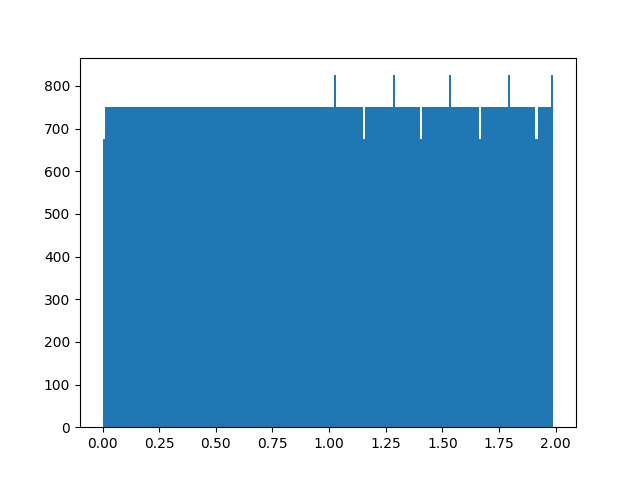

In [10]:
plt.figure()
plt.hist(test_label, bins=np.arange(0, 2, 0.01))
plt.show()

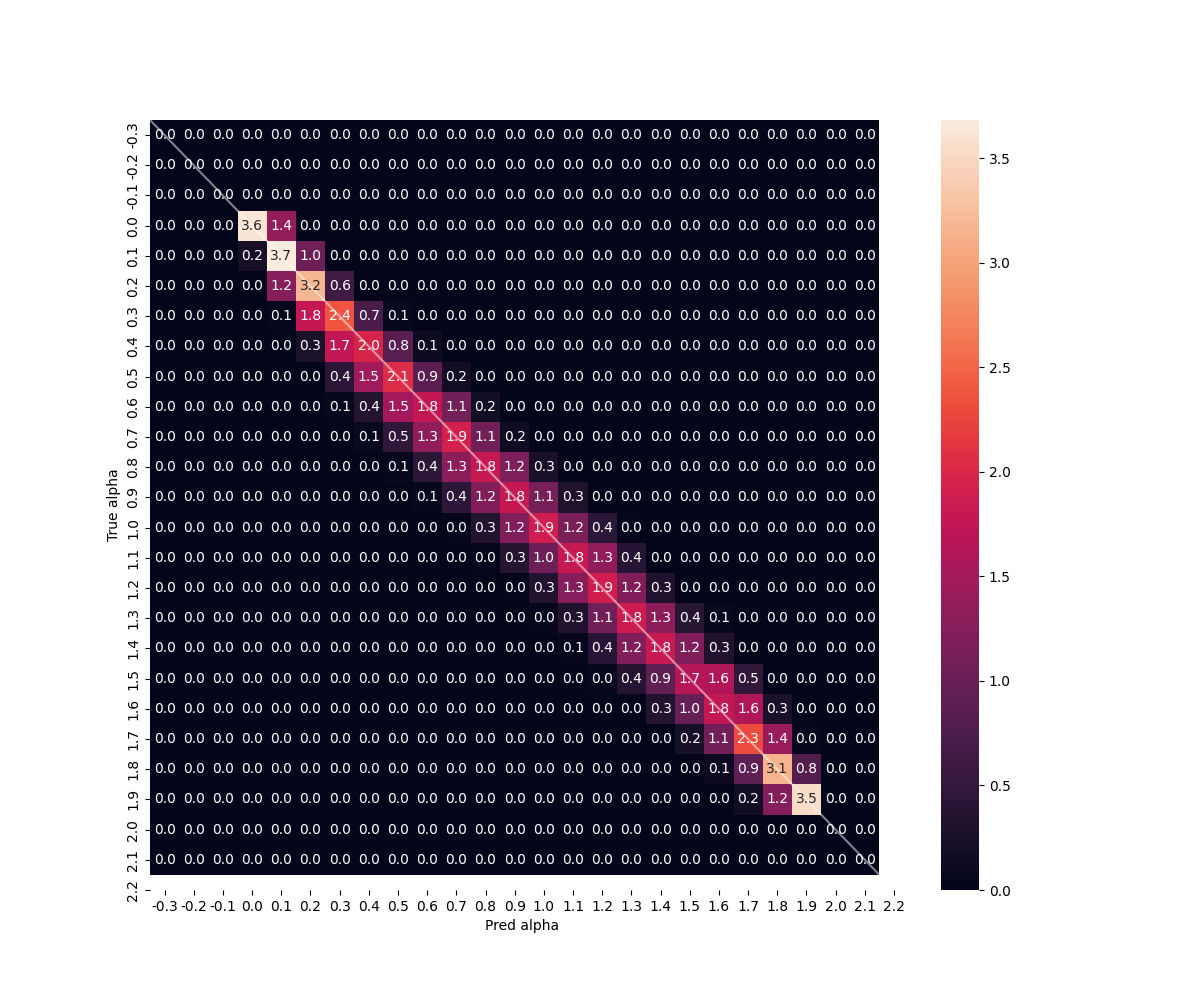

In [11]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(H, xticklabels=np.round(xedges, 1), yticklabels=np.round(yedges, 1), annot=True, fmt="3.1f")
ax.plot([0, 255],[0, 255], c='white', alpha=0.5, *ax.get_xlim())
ax.set(xlabel='Pred alpha', ylabel='True alpha')
plt.show()

In [14]:
alpha_range = np.arange(0.001, 2, 0.1)
pred_label = []
test_label = []

for alpha in alpha_range:
    print(f'alpha: {alpha}')
    test_data = []
    D = np.random.uniform(low=0.01, high=10.0)
    trajs_model, labels_model = models_phenom().single_state(N=100,
                                                             L=None,
                                                             T=test_T,
                                                             alphas=alpha,
                                                             Ds=[D, 0],
                                                            )
    for n_traj in range(100):
        for _ in range(25):
            random_start = np.random.randint(0, test_T - model_check)
            xs = trajs_model[:, n_traj, 0][random_start:random_start + model_check]
            ys = trajs_model[:, n_traj, 1][random_start:random_start + model_check]
            rad_list = radius_list(xs, ys)
                
            xs = xs / (np.std(xs))
            xs = np.cumsum(abs(uncumulate(xs))) / len(xs)
            ys = ys / (np.std(ys))
            ys = np.cumsum(abs(uncumulate(ys))) / len(ys)
            
            test_data.append(np.vstack((xs, rad_list)).T)
            test_data.append(np.vstack((ys, rad_list)).T)
    
    test_data = np.array(test_data).reshape(-1, model_check, 1, 2)
    pred = regression_model.predict(test_data, verbose=0)
    pred = pred.reshape(-1, 2).mean(axis=1)
    pred_label.append(pred)
    test_label.append([alpha] * len(pred))
    
pred_label = np.array(pred_label)
test_label = np.array(test_label)

alpha: 0.001
alpha: 0.101
alpha: 0.201
alpha: 0.30100000000000005
alpha: 0.401
alpha: 0.501
alpha: 0.6010000000000001
alpha: 0.7010000000000001
alpha: 0.801
alpha: 0.901
alpha: 1.001
alpha: 1.101
alpha: 1.201
alpha: 1.301
alpha: 1.401
alpha: 1.501
alpha: 1.601
alpha: 1.701
alpha: 1.801
alpha: 1.901


Total mean: 0.19152594064572098
Total std: 0.1621742578653178


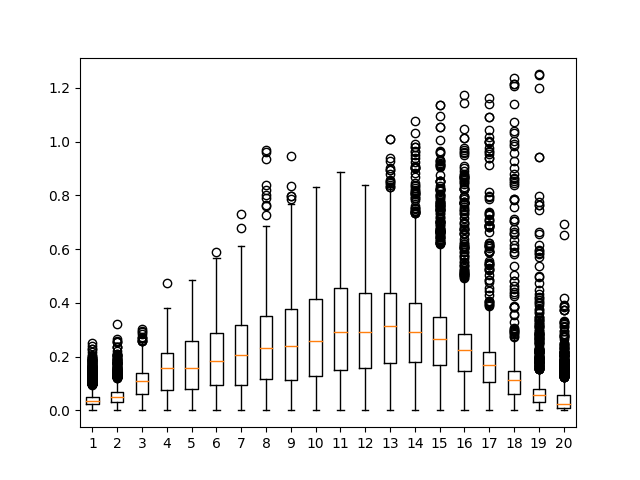

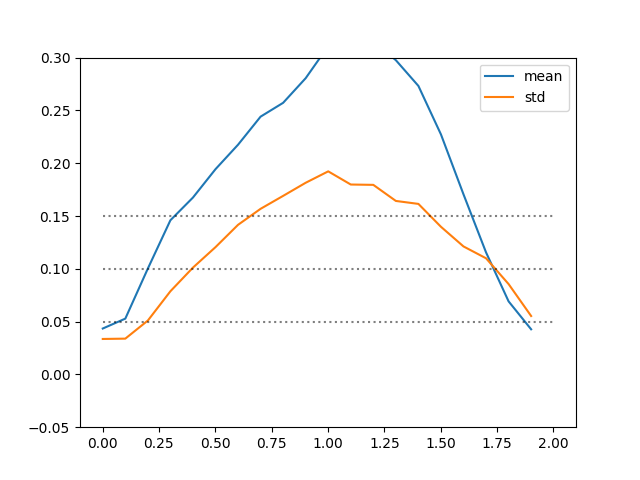

In [15]:
print(f'Total mean: {np.mean(abs(pred_label - test_label))}')
print(f'Total std: {np.std(abs(pred_label - test_label))}')
plt.figure()
plt.plot(alpha_range, np.mean(abs(pred_label - test_label), axis=1), label='mean')
plt.plot(alpha_range, np.std(abs(pred_label - test_label), axis=1), label='std')
plt.legend()
plt.hlines(y = 0.15, xmin = 0, xmax = 2.0, color="black", alpha=0.5, linestyle='dotted') 
plt.hlines(y = 0.1, xmin = 0, xmax = 2.0, color="black", alpha=0.5, linestyle='dotted') 
plt.hlines(y = 0.05, xmin = 0, xmax = 2.0, color="black", alpha=0.5, linestyle='dotted') 
plt.ylim([-0.05, 0.3])

plt.figure()
plt.boxplot(abs(pred_label - test_label).T)
plt.show()

In [24]:
alpha_range = np.arange(0.001, 2, 0.1)
pred_label = []
test_label = []

for alpha in alpha_range:
    print(f'alpha: {alpha}')
    test_data = []
    sub_pred = []
    
    D = np.random.uniform(low=0.01, high=10.0)
    trajs_model, labels_model = models_phenom().single_state(N=100,
                                                             L=None,
                                                             T=test_T,
                                                             alphas=alpha,
                                                             Ds=[D, 0],
                                                            )
    for n_traj in range(100):
        for _ in range(25):
            part_data = []
            random_start = np.random.randint(0, test_T - model_check)
            xs = trajs_model[:, n_traj, 0][random_start:random_start + model_check]
            ys = trajs_model[:, n_traj, 1][random_start:random_start + model_check]
            
            for i in range(0, len(xs), 2):
                cut_xs = xs[i : i+32]
                cut_ys = ys[i : i+32]
                if len(cut_xs) == 32:
                    rad_list = radius_list(cut_xs, cut_ys)

                    cut_xs = cut_xs / (np.std(cut_xs))
                    cut_xs = np.cumsum(abs(uncumulate(cut_xs))) / len(cut_xs)
                    cut_ys = cut_ys / (np.std(cut_ys))
                    cut_ys = np.cumsum(abs(uncumulate(cut_ys))) / len(cut_ys)

                    part_data.append(np.vstack((cut_xs, rad_list)).T)
                    part_data.append(np.vstack((cut_ys, rad_list)).T)
            part_data = np.array(part_data).reshape(-1, 32, 1, 2)
            
            pred = regression_model.predict(part_data, verbose=0)
            pred = pred.mean()
            sub_pred.append(pred)
    pred_label.append(sub_pred)
    test_label.append([alpha] * 2500)
    
pred_label = np.array(pred_label)
test_label = np.array(test_label)

alpha: 0.001
alpha: 0.101
alpha: 0.201
alpha: 0.30100000000000005
alpha: 0.401
alpha: 0.501
alpha: 0.6010000000000001
alpha: 0.7010000000000001
alpha: 0.801
alpha: 0.901
alpha: 1.001
alpha: 1.101
alpha: 1.201
alpha: 1.301
alpha: 1.401
alpha: 1.501
alpha: 1.601
alpha: 1.701
alpha: 1.801
alpha: 1.901


Total mean: 0.11294747056011317
Total std: 0.08801179521253712


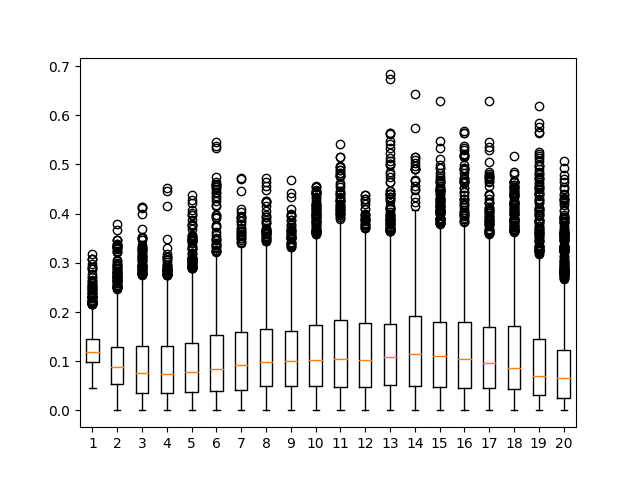

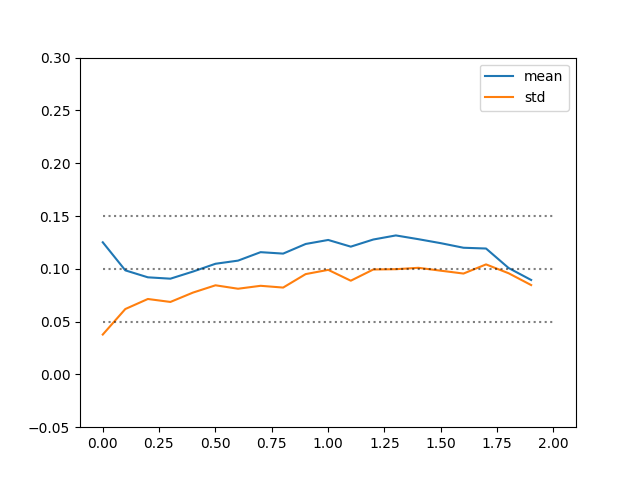

In [25]:
print(f'Total mean: {np.mean(abs(pred_label - test_label))}')
print(f'Total std: {np.std(abs(pred_label - test_label))}')
plt.figure()
plt.plot(alpha_range, np.mean(abs(pred_label - test_label), axis=1), label='mean')
plt.plot(alpha_range, np.std(abs(pred_label - test_label), axis=1), label='std')
plt.legend()
plt.hlines(y = 0.15, xmin = 0, xmax = 2.0, color="black", alpha=0.5, linestyle='dotted') 
plt.hlines(y = 0.1, xmin = 0, xmax = 2.0, color="black", alpha=0.5, linestyle='dotted') 
plt.hlines(y = 0.05, xmin = 0, xmax = 2.0, color="black", alpha=0.5, linestyle='dotted') 
plt.ylim([-0.05, 0.3])

plt.figure()
plt.boxplot(abs(pred_label - test_label).T)
plt.show()